In [171]:
# !conda install -c conda-forge scienceplots -y
# !conda install -c conda-forge tikzplotlib -y

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use("pgf")

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, PercentFormatter
#import tikzplotlib
#import scienceplots

In [173]:
#plt.style.use(['science', 'ieee'])

def set_size(width = 1, subplots=(1, 1)):
    width_pt = 426.79135
    fig_width_pt = width_pt * width
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)
cm = 1/2.54

mpl.rcParams.update({
    "pgf.texsystem": 'pdflatex',
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.labelsize": 10.0,
    "figure.titlesize": 10,
    "axes.titlesize": 10,
    "font.serif": [],
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
      r'\usepackage{amsmath}',
      r"\usepackage[utf8x]{inputenc}",
      r"\usepackage[T1]{fontenc}",
      r"\usepackage{cmbright}",
    ]),
    "figure.figsize": set_size(),
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.0,
    "legend.framealpha": 0.6,
    "legend.borderpad": 0.35,
    "legend.labelspacing": 0.4,
    "legend.handlelength": 2.0,
    "legend.handletextpad": 0.5,
    "legend.borderaxespad": 0.2,
    "legend.columnspacing": 1.0,
    "axes.grid": True,
    "grid.alpha": 0.5,
    "axes.labelpad": 1.0,
    "axes.titlepad": 1.0,
    "xtick.major.pad": 1.0,
    "xtick.minor.size": 2,
    "xtick.minor.pad": 1.0,
    "ytick.major.pad": 1.0,
    "ytick.minor.pad": 1.0,
    "ytick.minor.size": 2.0
})

figsize1 = (14.99786 * cm, 14.99786 * cm)
figsize1 = set_size()


In [174]:
color_map = {
    "CMSIS": "#ffb000",
    "TillJIT": "#785ef0",
    "TillJIT-4x6": "#785ef0",
    "TillJIT-4x3": "#ffb000",
    "Naive": "#648fff",
    "Peak": "red",
    "Intrinsics": "#dc267f"
}
linestyle_map = {
    "CMSIS": (0, (10, 1)),
    "TillJIT": "solid",
    "TillJIT-4x6": "solid",
    "TillJIT-4x3": "dotted",
    "Naive": (0, (1, 1)), # dense dotted
    "Peak": "dotted",
    "Intrinsics": "dashed"
}
marker_map = {
    # "CMSIS": '.',
    # "TillJIT": 'x',
    # "Intrinsics": "^",
    # "Naive": "1",
}

In [175]:
def calculateSpeedup(data, name1='TillJIT', name2='CMSIS'):
    tilljit_data = data[data['Type'] == name1]
    arm_data = data[data['Type'] == name2]

    merged_data = pd.merge(tilljit_data, arm_data, on=['M', 'K', 'N'], suffixes=('_tilljit', '_arm'))

    merged_data['Speedup'] = merged_data['GFLOPS_tilljit'] / merged_data['GFLOPS_arm']

    average_speedup = merged_data['Speedup'].mean()
    median_speedup = merged_data['Speedup'].median()
    maximum_speedup = merged_data['Speedup'].max()
    minimum_speedup = merged_data['Speedup'].min()

    print(f"Speedup Statistics ({name1} over {name2}):")
    print(f"Average Speedup: {average_speedup:.2f}x")
    print(f"Median Speedup: {median_speedup:.2f}x")
    print(f"Maximum Speedup: {maximum_speedup:.2f}x")
    print(f"Minimum Speedup: {minimum_speedup:.2f}x")

def plotFigure(csvPath, plotOver, peakPerf, xlabel, title, pgf_name, mark_intrinsics=False, figsize=figsize1, bbox=(1, 0.35), no_label=False, xlim=241):
    plt.clf()
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=figsize, layout='constrained')
    data = pd.read_csv(csvPath, sep=";")

    for type_exec in data['Type'].unique():
        subset = data[data['Type'] == type_exec]
        if type_exec == "Intrinsics" and mark_intrinsics:
            ax.scatter(subset[plotOver], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle=linestyle_map.get(type_exec, 'solid'), marker='^')
        else:
            ax.plot(subset[plotOver], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle=linestyle_map.get(type_exec, 'solid'), marker=marker_map.get(type_exec, None), markevery=(7,8), markersize=5)


    ax.axhline(y=peakPerf, color=color_map.get('Peak', 'black'), linestyle=linestyle_map.get('Peak', 'solid'), label='Peak')
    ax.set_xlim(0, xlim)
    if peakPerf == 1.6:
        ax.set_yticks([i for i in np.linspace(0, 1.6, 9)])
        ax.set_ylim(0, 1.65)
    # else:
    #     ticks = np.linspace(0, 0.6, 7)
    #     ax.set_yticks(list(ticks) + [peakPerf]) #, merged_data['Speedup'].max()])
    ax.set_xticks([i for i in range(0, xlim, 24)])
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3)) # 0, 8, 16, 24 ...
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 0.1, 0.2 ...

    ax2 = ax.twinx()
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=peakPerf))
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(ymin, ymax)
    ax2.plot([],[])
    if not no_label:
        ax2.set_ylabel("Erreichte Peak Perf.")
        ax.set_xlabel(xlabel)
        ax.set_ylabel('GFLOPS')
        ax.legend(loc='right', bbox_to_anchor=bbox, ncols=2)
        ax.set_title(title)
    ax.grid(True)
    plt.show()
    fig.savefig("pgf_export/" + pgf_name, format='pgf', backend='pgf')
    #tikzplotlib.save("tex_export/" + pgf_name.tex)
    return data, fig, ax


<Figure size 590.551x364.981 with 0 Axes>

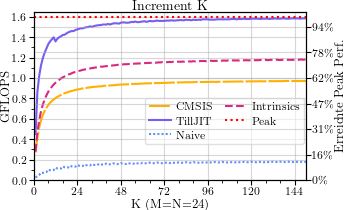

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.65x
Median Speedup: 1.63x
Maximum Speedup: 2.08x
Minimum Speedup: 1.63x


In [202]:
data, fig, ax = plotFigure('gemm_growing_k.csv', 'K', 1.6, 'K (M=N=24)', "Increment K", "grow_k.pgf", False, set_size(0.6), xlim=150)
calculateSpeedup(data, "TillJIT")

<Figure size 590.551x364.981 with 0 Axes>

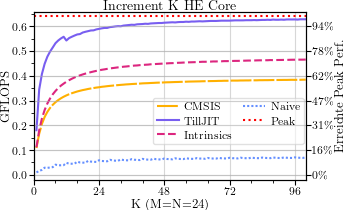

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.67x
Median Speedup: 1.65x
Maximum Speedup: 2.08x
Minimum Speedup: 1.63x


In [203]:
data, fig, ax = plotFigure('gemm_growing_k_he.csv', 'K', 0.64, 'K (M=N=24)', "Increment K HE Core", "grow_k_he.pgf", figsize=set_size(0.6), xlim=100)
calculateSpeedup(data)

<Figure size 590.551x364.981 with 0 Axes>

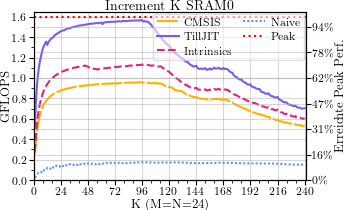

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.51x
Median Speedup: 1.43x
Maximum Speedup: 2.00x
Minimum Speedup: 1.32x


In [204]:
data, _, _ = plotFigure('gemm_growing_k_sram0.csv', 'K', 1.6, 'K (M=N=24)', "Increment K SRAM0", "grow_k_sram0.pgf", bbox=(1.0, 0.85), figsize=set_size(0.6))
calculateSpeedup(data)

# Square Tests

<Figure size 590.551x364.981 with 0 Axes>

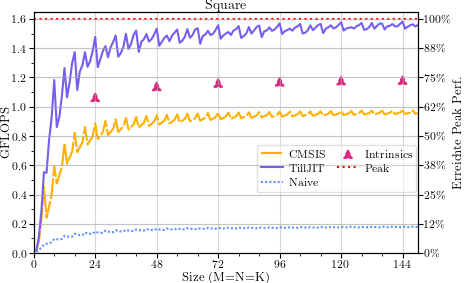

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.63x
Median Speedup: 1.62x
Maximum Speedup: 2.44x
Minimum Speedup: 1.23x


In [205]:
data, fig, ax = plotFigure('gemm_square_all.csv', 'M', 1.6, 'Size (M=N=K)', 'Square', 'square.pgf', True, figsize=set_size(0.8), xlim=150)
calculateSpeedup(data)


<Figure size 590.551x364.981 with 0 Axes>

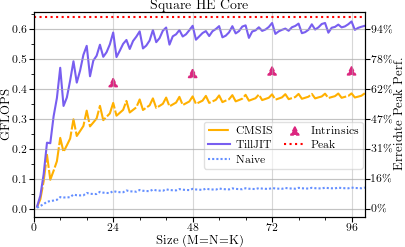

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.65x
Median Speedup: 1.63x
Maximum Speedup: 2.44x
Minimum Speedup: 1.23x


In [180]:
data, _, _ = plotFigure('gemm_square_he.csv', 'M', 0.64, 'Size (M=N=K)', "Square HE Core", "square_he.pgf", True, figsize=set_size(0.7), no_label=False, xlim=100)
calculateSpeedup(data)

<Figure size 590.551x364.981 with 0 Axes>

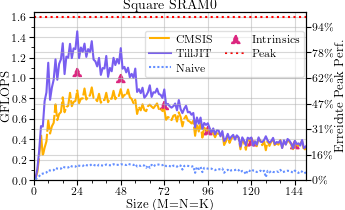

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.21x
Median Speedup: 1.12x
Maximum Speedup: 2.44x
Minimum Speedup: 0.93x


In [206]:
data, _, _ = plotFigure('gemm_square_sram0.csv', 'M', 1.6, 'Size (M=N=K)', 'Square SRAM0', 'square_sram0.pgf', True, bbox=(1, 0.75), figsize=set_size(0.6), xlim=150)
calculateSpeedup(data)

<Figure size 590.551x364.981 with 0 Axes>

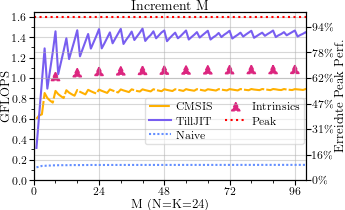

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.60x
Median Speedup: 1.63x
Maximum Speedup: 1.67x
Minimum Speedup: 0.52x


In [207]:
data, _, _ = plotFigure('gemm_growing_m.csv', 'M', 1.6, 'M (N=K=24)', 'Increment M', 'grow_m.pgf', True, figsize=set_size(0.6), xlim=100)
calculateSpeedup(data, "TillJIT")

<Figure size 590.551x364.981 with 0 Axes>

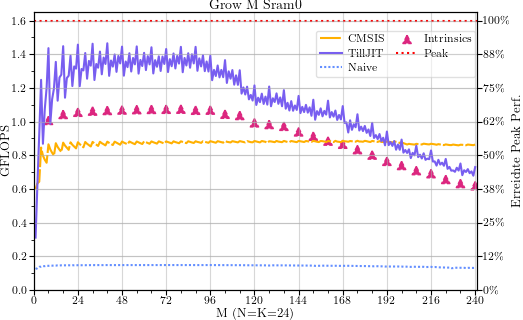

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.28x
Median Speedup: 1.30x
Maximum Speedup: 1.66x
Minimum Speedup: 0.52x


In [183]:
data, _, _ = plotFigure('gemm_growing_m_sram0.csv', 'M', 1.6, 'M (N=K=24)', "Grow M Sram0", 'grow_m_sram0.pgf', True, bbox=(1, 0.85), figsize=set_size(0.9))
calculateSpeedup(data, "TillJIT")

<Figure size 590.551x364.981 with 0 Axes>

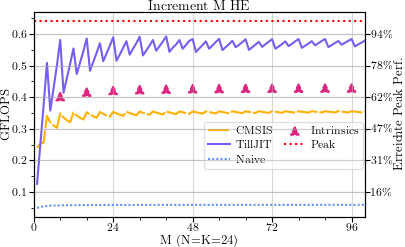

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.57x
Median Speedup: 1.61x
Maximum Speedup: 1.67x
Minimum Speedup: 0.52x


In [184]:
data, _, _ = plotFigure('gemm_growing_m_he.csv', 'M', 0.64, 'M (N=K=24)', 'Increment M HE', 'grow_m_he.pgf', True, figsize=set_size(0.7), xlim=100)
calculateSpeedup(data)

<Figure size 590.551x364.981 with 0 Axes>

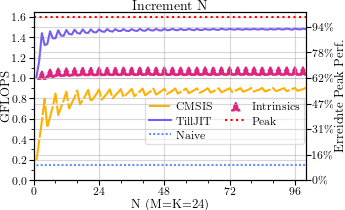

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.71x
Median Speedup: 1.66x
Maximum Speedup: 5.24x
Minimum Speedup: 1.63x


In [208]:
data, _, _ = plotFigure('gemm_growing_n.csv', 'N', 1.6, 'N (M=K=24)', 'Increment N', 'grow_n.pgf', True, figsize=set_size(0.6), xlim=100)
calculateSpeedup(data, "TillJIT")

<Figure size 590.551x364.981 with 0 Axes>

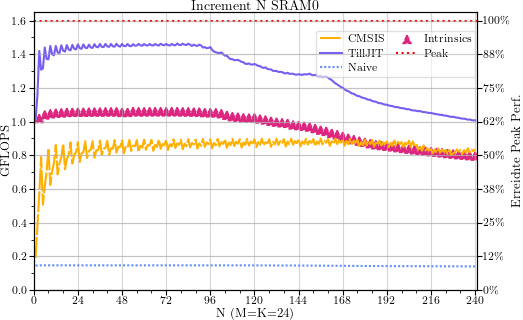

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.55x
Median Speedup: 1.52x
Maximum Speedup: 5.28x
Minimum Speedup: 1.20x


In [186]:
data, _, _ = plotFigure('gemm_growing_n_sram0.csv', 'N', 1.6, 'N (M=K=24)', 'Increment N SRAM0', 'grow_n_sram0.pgf', True, bbox=(1, 0.85), figsize=set_size(0.9))
calculateSpeedup(data)

<Figure size 590.551x364.981 with 0 Axes>

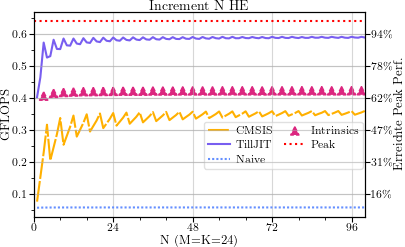

Speedup Statistics (TillJIT over CMSIS):
Average Speedup: 1.79x
Median Speedup: 1.70x
Maximum Speedup: 5.24x
Minimum Speedup: 1.63x


In [187]:
data, _, _ = plotFigure('gemm_growing_n_he.csv', 'N', 0.64, 'N (M=K=24)', 'Increment N HE', 'grow_n_he.pgf', True, figsize=set_size(0.7), xlim=100)
calculateSpeedup(data)

<Figure size 590.551x364.981 with 0 Axes>

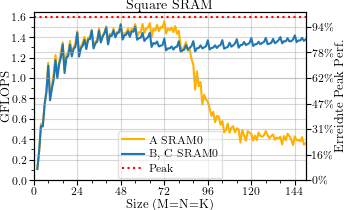

<Figure size 590.551x364.981 with 0 Axes>

In [209]:
import numpy as np
plt.clf()
fig, ax = plt.subplots(figsize=set_size(0.6), layout='constrained')

data = pd.read_csv('gemm_square_a_sram0.csv', sep=";")
ax.plot(data['M'], data['GFLOPS'], label="A SRAM0", color=color_map.get('CMSIS'))

data = pd.read_csv('gemm_square_bc_sram0.csv', sep=";")
ax.plot(data['M'], data['GFLOPS'], label="B, C SRAM0", color=color_map.get('JIT'))

ax.axhline(y=1.6, color=color_map.get('Peak', 'black'), linestyle=linestyle_map.get('Peak', 'solid'), label='Peak')
ax.set_xlim(0, 150)
ax.set_xticks([i for i in range(0, 150, 24)])
ax.set_yticks([i for i in np.linspace(0, 1.6, 9)])
ax.set_ylim(0, 1.65)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3)) # 0, 8, 16, 24 ...
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 0.1, 0.2 ...
ax.set_xlabel('Size (M=N=K)')
ax.set_ylabel('GFLOPS')

ax2 = ax.twinx()
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1.6))
ymin, ymax = ax.get_ylim()
ax2.set_ylim(ymin, ymax)
ax2.plot([],[])
ax2.set_ylabel("Erreichte Peak Perf.")

#plt.legend(loc='lower right')
ax.legend()
ax.grid(True)
ax.set_title("Square SRAM")
plt.show()
plt.savefig("pgf_export/square_storage.pgf", format='pgf', backend='pgf')


<Figure size 590.551x364.981 with 0 Axes>

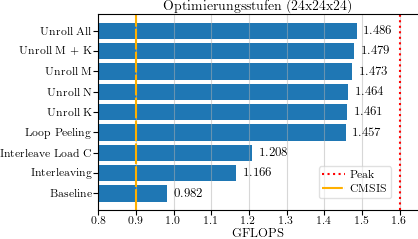

In [189]:
data = pd.read_csv('ablation.csv', sep=";")
plt.clf()
fig, ax = plt.subplots(figsize=set_size(0.7))

average_gflops = data.groupby('Test')['GFLOPS'].mean().sort_values(ascending=True)

bars = ax.barh(range(len(average_gflops)), average_gflops.values)

for i, (bar, value) in enumerate(zip(bars, average_gflops.values)):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
        f'{value:.3f}', ha='left', va='center', fontsize=9)


ax.set_yticks(range(len(average_gflops)))
ax.set_yticklabels(average_gflops.index)
ax.set_xlabel('GFLOPS')
ax.set_title('Optimierungsstufen (24x24x24)')

ax.axvline(x=1.6, color=color_map.get('Peak'), linestyle=linestyle_map.get('Peak'), label='Peak')
ax.axvline(x=0.9, color=color_map.get('CMSIS'), linestyle=linestyle_map.get('CMSIS'), label='CMSIS')
ax.set_xlim(left=0.8, right=1.65)

ax.grid(axis='y')
ax.legend(loc='lower right', bbox_to_anchor=(0.92, 0.05))

plt.savefig("pgf_export/ablation.pgf", format='pgf', backend='pgf')

plt.show()

In [190]:
data = pd.read_csv('ablation.csv', sep=";")
data['IPC'] = round(data['InstrCount'] / data['Cycles'], 2)
data
data.to_csv('ablation.csv', sep=";", index=False)

In [191]:
def filter_microkernel(data, defM=8, defN=3):
    def use46(row):
        m, n = row['M'], row['N']
        cond1 = (m <= 4) and (n > 3)
        cond2 = (
            (m % defM != 0) and (m % defM <= 4) and ((n - (n % defN)) % 6 == 0)
        )
        cond3 = n > 3
        return (cond1 or cond2) and cond3
    
    mask = data.apply(use46, axis=1)
    return data[mask]

def plotFigure4x36(csvPath, plotOver, peakPerf, xlabel, title, pgf_name, mark_intrinsics=False, figsize=figsize1, bbox=(1, 0.35), no_label=False, xlim=241):
    plt.clf()
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=figsize, layout='constrained')
    data1 = pd.read_csv(csvPath, sep=";")
    data = filter_microkernel(data1)
    data = data[data['GFLOPS'] >= 1]
    for type_exec in data['Type'].unique():
        subset = data[data['Type'] == type_exec]
        ax.plot(subset[plotOver], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle='dotted', marker= ('*' if type_exec == 'TillJIT-4x6' else 'x'))

    ax.axhline(y=peakPerf, color=color_map.get('Peak', 'black'), linestyle=linestyle_map.get('Peak', 'solid'), label='Peak')
    ax.set_xlim(0, xlim)
    if peakPerf == 1.6:
        #ax.set_yticks([i for i in np.linspace(1.1, 1.6, 9)])
        ax.set_ylim(1.18, 1.62)
    ax.set_xticks([i for i in range(0, xlim, 24)])
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=3)) # 0, 8, 16, 24 ...
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 0.1, 0.2 ...
    ax.tick_params(axis='x', which='minor', length=2, direction='out')
    ax.tick_params(axis='y', which='minor', length=2, direction='out')

    ax2 = ax.twinx()
    ax2.set_ylabel("Erreichte Peak Perf.")
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=peakPerf))
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(ymin, ymax)
    ax2.plot([],[])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('GFLOPS')
    ax.legend(loc='right', bbox_to_anchor=bbox)
    ax.grid(True)
    ax.set_title(title)
    plt.show()
    fig.savefig("pgf_export/" + pgf_name, format='pgf', backend='pgf')
    return data, fig, ax

<Figure size 590.551x364.981 with 0 Axes>

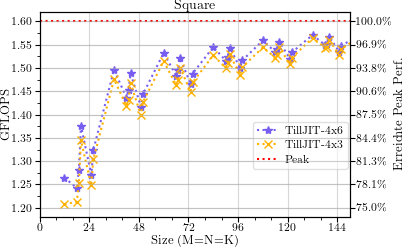

Speedup Statistics (TillJIT-4x6 over TillJIT-4x3):
Average Speedup: 1.01x
Median Speedup: 1.01x
Maximum Speedup: 1.05x
Minimum Speedup: 1.00x


In [192]:
data, _, _ = plotFigure4x36('4x6_tests.csv', 'M', 1.6, 'Size (M=N=K)', 'Square', 'square4x6.pgf', True, xlim=150, figsize=set_size(0.7))
calculateSpeedup(data, "TillJIT-4x6", "TillJIT-4x3")

In [193]:
def plotFigureAllSizes(csvPath, plotOver, peakPerf, xlabel, title, pgf_name, mark_intrinsics=False):
    plt.clf()
    fig, ax = plt.subplots(figsize=set_size(0.7))
    data = pd.read_csv(csvPath, sep=";")
    tilljit_data = data[data['Type'] == "TillJIT"]
    arm_data = data[data['Type'] == "CMSIS"]

    merged_data = pd.merge(tilljit_data, arm_data, on=['M', 'K', 'N'], suffixes=('_tilljit', '_arm'))
    merged_data = merged_data[merged_data['K'] == 16]

    merged_data['Speedup'] = merged_data['GFLOPS_tilljit'] / merged_data['GFLOPS_arm']
    merged_data = merged_data.sort_values('Speedup')
    ax.plot(range(len(merged_data)), merged_data['Speedup'], label='Speedup', color=color_map.get('TillJIT', 'black'))


    ax.axhline(y=merged_data['Speedup'].mean(), color=color_map.get('Peak', 'black'), linestyle='--', label='Durchschnittlicher Speedup')
    # ax.set_xticks([i for i in range(0, 241, 24)])
    # ax.xaxis.set_minor_locator(AutoMinorLocator(n=3)) # 0, 8, 16, 24 ...
    # ax.yaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 0.1, 0.2 ...
    ax.tick_params(axis='x', which='minor', length=2, direction='out')
    ax.tick_params(axis='y', which='minor', length=2, direction='out')

    # ax2 = ax.twinx()
    # ax2.set_ylabel("M")
    # #ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    # ymin, ymax = ax.get_ylim()
    # ax2.set_ylim(0, 32)
    # rolling_avg_m = merged_data['M'].rolling(window=30, center=True).mean()
    # rolling_avg_n = merged_data['N'].rolling(window=30, center=True).mean()
    # ax2.plot(range(len(merged_data)), rolling_avg_m, label='M', color='magenta')
    # ax2.plot(range(len(merged_data)), rolling_avg_n, label='N', color='blue')


    ax.set_xlabel(xlabel)
    ax.set_ylabel('Speedup')
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
    ax.grid(True)
    ax.set_title(title)
    plt.show()
    fig.savefig("pgf_export/" + pgf_name, format='pgf', backend='pgf')
    return merged_data, fig, ax



<Figure size 590.551x364.981 with 0 Axes>

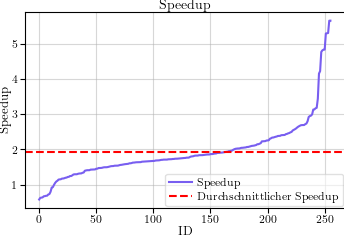

In [194]:
data1, _, _ = plotFigureAllSizes('gemm_all_sizes.csv', 'M/N', 1.6, 'ID', 'Speedup', 'speedup_all_sizes_1d.pgf', True)
# calculateSpeedup(data1, "TillJIT", "ARM-CMSIS-DSP")

<Figure size 590.551x364.981 with 0 Axes>

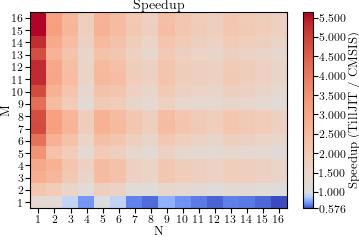

1.9379085275699537

In [195]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import numpy as np
def plotFigureAllSizes2d(csvPath, plotOver, peakPerf, xlabel, title, pgf_name, mark_intrinsics=False):
    plt.clf()
    fig, ax = plt.subplots(figsize=set_size(0.7))
    data = pd.read_csv(csvPath, sep=";")
    tilljit_data = data[data['Type'] == "TillJIT"]
    arm_data = data[data['Type'] == "CMSIS"]

    # Merge datasets on common dimensions (M, K, N)
    merged_data = pd.merge(tilljit_data, arm_data, on=['M', 'K', 'N'], suffixes=('_tilljit', '_arm'))
    merged_data['Speedup'] = merged_data['GFLOPS_tilljit'] / merged_data['GFLOPS_arm']
    merged_data = merged_data.sort_values('Speedup')
    merged_data = merged_data[merged_data['K'] == 16]
    #merged_data = merged_data.groupby(['M', 'N'], as_index=False)['Speedup'].mean()
    merged_matrix = merged_data.pivot(index='M', columns='N', values='Speedup')
    offset = mcolors.TwoSlopeNorm(vmin=merged_data['Speedup'].min(), vcenter=1, vmax=merged_data['Speedup'].max())

    im =  ax.imshow(merged_matrix, norm=offset, cmap='coolwarm', aspect='auto', origin='lower')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Speedup (TillJIT / CMSIS)')
    cbar.ax.set_yscale('linear') # https://github.com/matplotlib/matplotlib/issues/22197
    #cbar.ax.set_yticks(range(0, int(merged_data['Speedup'].max()), 0.5))
    #cbar.ax.yaxis.set_major_locator(mticker.IndexLocator(base=merged_data['Speedup'].min(), offset=0))
    cbar.ax.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
    ticks = np.linspace(1, 5.5, 10)
    cbar.ax.set_yticks(list(ticks) + [merged_data['Speedup'].min()]) #, merged_data['Speedup'].max()])
    ax.set_xticks(range(len(merged_matrix.columns)))
    ax.set_xticklabels(merged_matrix.columns)
    ax.set_yticks(range(len(merged_matrix.index)))
    ax.set_yticklabels(merged_matrix.index)
    ax.grid(False)
    ax.set_xlabel('N')
    ax.set_ylabel('M')
    ax.set_title(title)
    plt.show()
    fig.savefig("pgf_export/" + pgf_name, format='pgf', backend='pgf')

    return merged_data, fig, ax

data1, _, _ = plotFigureAllSizes2d('gemm_all_sizes.csv', 'M/N', 1.6, 'ID', 'Speedup', 'speedup_all_sizes_2d.pgf', True)
data1['Speedup'].mean()

<Figure size 590.551x364.981 with 0 Axes>

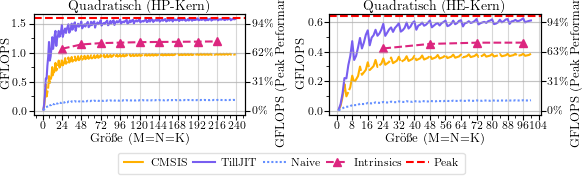

In [196]:
plt.clf()
xlabel='Größe (M=N=K)'
title='Quadratisch (HP-Kern)'
pgf_name = 'square_sbs.pgf'
fig, (ax, axhe) = plt.subplots(ncols=2, figsize=set_size(1, (1,2)))
data = pd.read_csv('gemm_square_all.csv', sep=";")

for type_exec in data['Type'].unique():
    subset = data[data['Type'] == type_exec]
    if type_exec == "Intrinsics":
        ax.plot(subset['M'], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle=linestyle_map.get(type_exec, 'solid'), marker='^')
    else:
        ax.plot(subset['M'], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle=linestyle_map.get(type_exec, 'solid'))


ax.axhline(y=1.6, color=color_map.get('Peak', 'black'), linestyle='--', label='Peak')
ax.set_xticks([i for i in range(0, 241, 24)])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3)) # 0, 8, 16, 24 ...
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 0.1, 0.2 ...
ax.tick_params(axis='x', which='minor', length=2, direction='out')
ax.tick_params(axis='y', which='minor', length=2, direction='out')

ax2 = ax.twinx()
ax2.set_ylabel("GFLOPS (Peak Performance)")
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1.6))
ymin, ymax = ax.get_ylim()
ax2.set_ylim(ymin, ymax)
ax2.plot([],[])
ax.set_xlabel(xlabel)
ax.set_ylabel('GFLOPS')

data = pd.read_csv('gemm_square_he.csv', sep=";")

for type_exec in data['Type'].unique():
    subset = data[data['Type'] == type_exec]
    if type_exec == "Intrinsics":
        axhe.plot(subset['M'], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle=linestyle_map.get(type_exec, 'solid'), marker='^')
    else:
        axhe.plot(subset['M'], subset['GFLOPS'], label=type_exec, color=color_map.get(type_exec, 'black'), linestyle=linestyle_map.get(type_exec, 'solid'))


axhe.axhline(y=0.64, color=color_map.get('Peak', 'black'), linestyle='--', label='Peak')
axhe.set_xticks([i for i in range(0, 241, 8)])
axhe.xaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 8, 16, 24 ...
axhe.yaxis.set_minor_locator(AutoMinorLocator(n=2)) # 0, 0.1, 0.2 ...
axhe.tick_params(axis='x', which='minor', length=2, direction='out')
axhe.tick_params(axis='y', which='minor', length=2, direction='out')

axhe2 = axhe.twinx()
axhe2.set_ylabel("GFLOPS (Peak Performance)")
axhe2.yaxis.set_major_formatter(PercentFormatter(xmax=0.64))
ymin, ymax = axhe.get_ylim()
axhe2.set_ylim(ymin, ymax)
axhe2.plot([],[])
axhe.set_xlabel(xlabel)
axhe.set_ylabel('GFLOPS')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside lower center', bbox_transform = plt.gcf().transFigure, columnspacing= 0.5, labelspacing=0, borderpad=0.5, ncols=5)

#fig.legend(loc='right', bbox_to_anchor=(1, 0.35))
ax.grid(True)
ax.set_title(title)
axhe.grid(True)
axhe.set_title("Quadratisch (HE-Kern)")

fig.set_layout_engine('constrained')
#fig.tight_layout()
plt.show()
fig.savefig("pgf_export/" + pgf_name, format='pgf', backend='pgf')

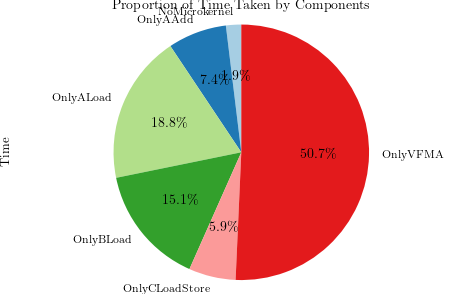

In [197]:
data = pd.read_csv('components_include_additive_slow.csv', sep=";")

# Take the absolute value of the 'Time' column
data['Time'] = data['Time'].abs()

# Group by 'Test' and calculate the total time for each component
total_time = data[data['Test'].isin(['NoMicrokernel', 'OnlyCLoadStore', 'OnlyAAdd', 'OnlyBLoad', 'OnlyALoad', 'OnlyVFMA'])].groupby('Test')['Time'].mean()

# Create the pie chart
total_time.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Proportion of Time Taken by Components')

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

# Show the plot
plt.show()

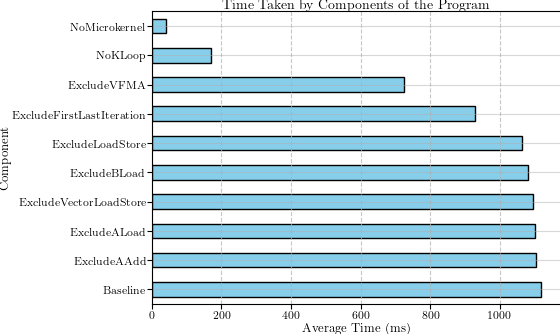

In [198]:
# Load the data
data = pd.read_csv('components_exclude.csv', sep=";")
data['Time'] = data['Time'].abs()
# Group by 'Test' and calculate the average time for each component
average_time = data.groupby('Test')['Time'].mean().sort_values(ascending=False)

# Create a horizontal bar plot
average_time.plot(kind='barh', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Average Time (ms)')
plt.ylabel('Component')
plt.title('Time Taken by Components of the Program')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

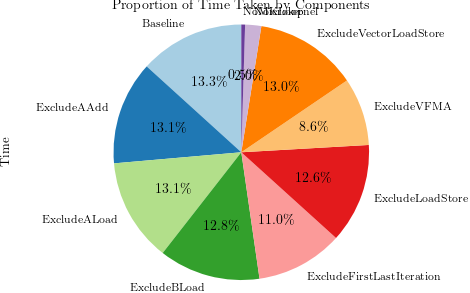

In [199]:
data = pd.read_csv('components_exclude.csv', sep=";")

# Take the absolute value of the 'Time' column
data['Time'] = data['Time'].abs()

# Group by 'Test' and calculate the total time for each component
total_time = data.groupby('Test')['Time'].sum()

# Create the pie chart
total_time.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Proportion of Time Taken by Components')

# Equal aspect ratio ensures the pie chart is circular
plt.axis('equal')

# Show the plot
plt.show()

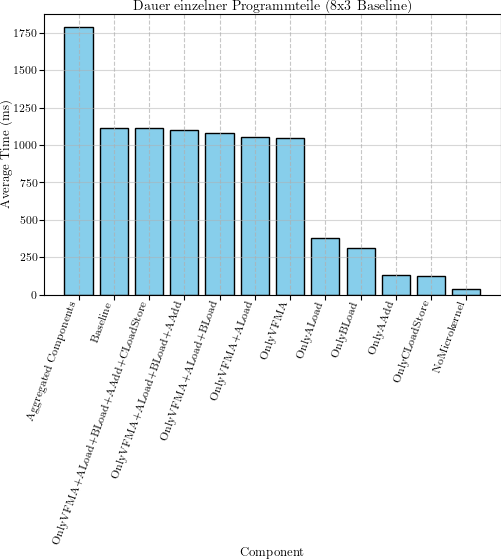

In [200]:
# Load the data
data = pd.read_csv('components_include_additive.csv', sep=";")
data['Time'] = data['Time'].abs()

average_time = data.groupby('Test')['Time'].mean().reset_index()
nomicrokernel_time = data[data['Test'] == 'NoMicrokernel']['Time'].mean()
aggregated_value = average_time[average_time['Test'].isin(['NoMicrokernel', 'OnlyCLoadStore', 'OnlyAAdd', 'OnlyBLoad', 'OnlyALoad', 'OnlyVFMA'])]['Time'].sum()
aggregated_value -= 6 * nomicrokernel_time

# Add the aggregated value as a new row using pd.concat
aggregated_row = pd.DataFrame({'Test': ['Aggregated Components'], 'Time': [aggregated_value]})
aggregated_data = pd.concat([average_time, aggregated_row], ignore_index=True)
aggregated_data = aggregated_data.sort_values(by='Time', ascending=False)


# Create a horizontal bar plot
plt.bar(aggregated_data['Test'], aggregated_data['Time'], color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Average Time (ms)')
plt.xlabel('Component')
plt.title('Dauer einzelner Programmteile (8x3 Baseline)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=70, ha='right')

# Show the plot
plt.show()

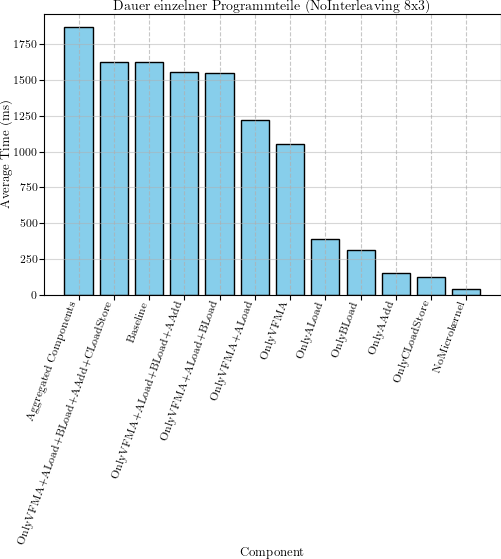

In [201]:
# Load the data
data = pd.read_csv('components_include_additive_slow.csv', sep=";")
data['Time'] = data['Time'].abs()

average_time = data.groupby('Test')['Time'].mean().reset_index()
nomicrokernel_time = data[data['Test'] == 'NoMicrokernel']['Time'].mean()
aggregated_value = average_time[average_time['Test'].isin(['NoMicrokernel', 'OnlyCLoadStore', 'OnlyAAdd', 'OnlyBLoad', 'OnlyALoad', 'OnlyVFMA'])]['Time'].sum()
aggregated_value -= 5 * nomicrokernel_time

# Add the aggregated value as a new row using pd.concat
aggregated_row = pd.DataFrame({'Test': ['Aggregated Components'], 'Time': [aggregated_value]})
aggregated_data = pd.concat([average_time, aggregated_row], ignore_index=True)
aggregated_data = aggregated_data.sort_values(by='Time', ascending=False)

# Create a horizontal bar plot
plt.bar(aggregated_data['Test'], aggregated_data['Time'], color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Average Time (ms)')
plt.xlabel('Component')
plt.title('Dauer einzelner Programmteile (NoInterleaving 8x3)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=70, ha='right')

# Show the plot
plt.show()